In [5]:
# test_rm.py
import heapq
import matplotlib.pyplot as plt
from collections import defaultdict
from RM import RMScheduler, Task, Job  # Import from your RM implementation file

def test_rm_scheduling():
    # Create a simple test scenario with 1 core and 3 tasks
    scheduler = RMScheduler(
        num_cores=1,
        allocation_policy='partitioned_best_fit',
        is_preemptive=True
    )
    
    # Manually create tasks with different periods and WCETs
    tasks = [
        Task(id=0, period=5, wcet=1, net=1, utilization=0.2),    # Highest priority (shortest period)
        Task(id=1, period=7, wcet=2, net=1, utilization=2/7),    # Medium priority
        Task(id=2, period=12, wcet=3, net=2, utilization=0.25)   # Lowest priority
    ]
    
    # Allocate tasks to core (since we're testing partitioned)
    scheduler.cores[0].tasks = tasks.copy()
    for task in tasks:
        task.core_assignment = 0
    
    # Simulate for 40 time units (enough to see several periods)
    max_time = 40
    scheduler._simulate_core_preemptive_rm(scheduler.cores[0], max_time)
    
    # Collect and visualize the schedule
    schedule = scheduler.cores[0].schedule
    task_colors = {0: 'red', 1: 'green', 2: 'blue'}
    
    # Create a timeline visualization
    plt.figure(figsize=(15, 5))
    
    # Plot each job execution
    for start, end, task_id, _ in schedule:
        plt.barh(y=0, width=end-start, left=start, color=task_colors[task_id], edgecolor='black')
        plt.text((start+end)/2, 0, f'T{task_id}', ha='center', va='center', color='white')
    
    # Mark deadlines for each task
    for task in tasks:
        deadlines = range(task.period, max_time + task.period, task.period)
        for d in deadlines:
            if d <= max_time:
                plt.axvline(x=d, color=task_colors[task.id], linestyle='--', alpha=0.5)
    
    plt.yticks([])
    plt.xlabel('Time')
    plt.title('RM Schedule Visualization')
    plt.grid(True, axis='x')
    plt.show()
    
    # Print job execution details
    print("\nJob Execution Details:")
    print("Time | Task | Execution | Deadline")
    print("-----|------|-----------|---------")
    for start, end, task_id, exec_time in schedule:
        task = tasks[task_id]
        job_deadline = start - (start % task.period) + task.period
        print(f"{start:4}-{end:<4} | T{task_id}   | {exec_time:4}/{task.wcet:<4} | {job_deadline:<7}")
    
    # Print task metrics
    print("\nTask Metrics:")
    print("Task | Period | WCET | NET | Jobs | Missed | Max Response")
    print("-----|--------|------|-----|------|--------|-------------")
    for task in tasks:
        print(f"T{task.id:<4} | {task.period:<6} | {task.wcet:<4} | {task.net:<3} | {task.total_jobs:<4} | {task.missed_deadlines:<6} | {task.max_response:<11}")
    
    # Verify RM properties
    verify_rm_properties(schedule, tasks, max_time)

def verify_rm_properties(schedule, tasks, max_time):
    print("\nVerifying RM Properties:")
    
    # 1. Check that higher priority tasks (shorter period) preempt lower priority ones
    preemptions = defaultdict(int)
    current_task = None
    prev_task = None
    
    for start, end, task_id, _ in schedule:
        if current_task is None:
            current_task = task_id
        elif task_id != current_task:
            # Check if this is a valid preemption (new task has higher priority)
            new_task = next(t for t in tasks if t.id == task_id)
            old_task = next(t for t in tasks if t.id == current_task)
            
            if new_task.period < old_task.period:
                preemptions[(old_task.id, new_task.id)] += 1
            else:
                print(f"Warning: Invalid preemption at time {start} - T{new_task.id} (period {new_task.period}) "
                      f"preempted T{old_task.id} (period {old_task.period})")
            current_task = task_id
    
    print("\n1. Preemption Analysis:")
    if preemptions:
        for (old_id, new_id), count in preemptions.items():
            print(f"T{new_id} preempted T{old_id} {count} times (correct priority order)")
    else:
        print("No preemptions occurred in this schedule")
    
    # 2. Check Liu & Layland bound
    print("\n2. Liu & Layland Schedulability Test:")
    n = len(tasks)
    total_utilization = sum(task.utilization for task in tasks)
    ll_bound = n * (2 ** (1/n) - 1)
    
    print(f"Total utilization: {total_utilization:.3f}")
    print(f"Liu & Layland bound for {n} tasks: {ll_bound:.3f}")
    
    if total_utilization <= ll_bound:
        print("✓ System guaranteed schedulable under RM (U ≤ n(2^(1/n)-1))")
        if any(task.missed_deadlines for task in tasks):
            print("  Warning: Deadlines missed despite passing LL bound (check implementation)")
    else:
        print("✗ Utilization exceeds LL bound - system may or may not be schedulable")
        if total_utilization <= 1.0:
            print("  Note: Utilization ≤ 1.0 - system might still be schedulable")
    
    # 3. Check response times
    print("\n3. Response Time Analysis:")
    for task in sorted(tasks, key=lambda x: x.period):
        expected_max_response = task.period  # For tasks with utilization ≤ LL bound
        print(f"T{task.id}: Period={task.period}, Max response={task.max_response}", end=" ")
        if task.max_response <= expected_max_response:
            print("✓ Within expected bound")
        else:
            print("✗ Exceeds period!")

def test_multicore_rm():
    """Test multicore RM scheduling with partitioned approach"""
    print("\n=== Testing Multicore RM Scheduling (3 cores, 9 tasks) ===")
    scheduler = RMScheduler(
        num_cores=3,
        allocation_policy='partitioned_best_fit',
        is_preemptive=True
    )
    
    # Create tasks with harmonic periods (better for RM)
    tasks = [
        # Core 0 candidates (high priority)
        Task(id=0, period=5, wcet=1, net=1, utilization=0.2),
        Task(id=1, period=10, wcet=2, net=1, utilization=0.2),
        Task(id=2, period=20, wcet=3, net=2, utilization=0.15),
        
        # Core 1 candidates
        Task(id=3, period=6, wcet=1, net=1, utilization=0.17),
        Task(id=4, period=12, wcet=2, net=1, utilization=0.17),
        Task(id=5, period=24, wcet=3, net=2, utilization=0.125),
        
        # Core 2 candidates
        Task(id=6, period=7, wcet=1, net=1, utilization=0.14),
        Task(id=7, period=14, wcet=2, net=1, utilization=0.14),
        Task(id=8, period=28, wcet=3, net=2, utilization=0.11)
    ]
    
    # Allocate tasks using best-fit partitioning
    scheduler.allocate_tasks(tasks)
    
    # Print allocation
    print("\nTask Allocation:")
    for core in scheduler.cores:
        print(f"Core {core.id}: Tasks {[t.id for t in core.tasks]}, "
              f"Utilization: {sum(t.utilization for t in core.tasks):.2f}")
    
    # Simulate for 100 time units
    max_time = 100
    scheduler.simulate(tasks, max_time)
    
    # Visualize schedules
    visualize_multicore_schedules(scheduler, max_time)
    
    # Analyze results
    analyze_multicore_results(scheduler, tasks)

def visualize_multicore_schedules(scheduler, max_time):
    """Create Gantt charts for each core"""
    plt.figure(figsize=(15, 10))
    
    # Create consistent colors for tasks across cores
    all_tasks = set()
    for core in scheduler.cores:
        all_tasks.update([t.id for t in core.tasks])
    colors = plt.cm.get_cmap('tab10', len(all_tasks))
    task_colors = {task_id: colors(i) for i, task_id in enumerate(sorted(all_tasks))}
    
    for i, core in enumerate(scheduler.cores):
        plt.subplot(len(scheduler.cores), 1, i+1)
        
        for start, end, task_id, _ in core.schedule:
            plt.barh(y=0, width=end-start, left=start, 
                    color=task_colors[task_id], edgecolor='black')
            plt.text((start+end)/2, 0, f'T{task_id}', 
                    ha='center', va='center', color='white')
        
        # Mark deadlines for each task
        for task in core.tasks:
            deadlines = range(task.period, max_time + task.period, task.period)
            for d in deadlines:
                if d <= max_time:
                    plt.axvline(x=d, color=task_colors[task.id], 
                              linestyle='--', alpha=0.3)
        
        plt.yticks([])
        plt.ylabel(f'Core {core.id}')
        plt.grid(True, axis='x')
    
    plt.xlabel('Time')
    plt.suptitle('Multicore RM Schedules')
    plt.tight_layout()
    plt.show()

def analyze_multicore_results(scheduler, tasks):
    """Analyze results from multicore RM scheduling"""
    print("\n=== Multicore RM Results ===")
    
    # Core-level analysis
    print("\nCore Statistics:")
    print("Core | Tasks | Utilization | Missed Deadlines")
    print("-----|-------|-------------|-----------------")
    for core in scheduler.cores:
        core_tasks = [t for t in tasks if t.core_assignment == core.id]
        missed = sum(t.missed_deadlines for t in core_tasks)
        print(f"{core.id:4} | {len(core.tasks):5} | {core.utilization:11.2f} | {missed:15}")
    
    # Task-level analysis
    print("\nTasks with Missed Deadlines:")
    print("Task | Core | Period | WCET | Jobs | Missed | Response")
    print("-----|------|--------|------|------|--------|---------")
    for task in sorted(tasks, key=lambda x: x.core_assignment):
        if task.missed_deadlines > 0:
            print(f"T{task.id:4} | {task.core_assignment:4} | {task.period:6} | "
                  f"{task.wcet:4} | {task.total_jobs:4} | {task.missed_deadlines:6} | "
                  f"{task.max_response:8}")
    
    # Verify RM properties per core
    print("\nRM Property Verification per Core:")
    for core in scheduler.cores:
        print(f"\nCore {core.id}:")
        tasks_on_core = [t for t in tasks if t.core_assignment == core.id]
        total_util = sum(t.utilization for t in tasks_on_core)
        n = len(tasks_on_core)
        ll_bound = n * (2 ** (1/n) - 1) if n > 0 else 0
        
        print(f"Tasks: {[t.id for t in tasks_on_core]}")
        print(f"Utilization: {total_util:.3f}")
        print(f"Liu & Layland bound: {ll_bound:.3f}")
        
        if total_util <= ll_bound:
            print("✓ Passes LL schedulability test")
            if any(t.missed_deadlines for t in tasks_on_core):
                print("  Warning: Deadlines missed despite passing LL bound")
        else:
            print("✗ Fails LL test (may still be schedulable)")
            if total_util <= 1.0 and not any(t.missed_deadlines for t in tasks_on_core):
                print("  Note: System is empirically schedulable despite failing LL test")

def test_nonpreemptive_rm():
    """Test non-preemptive RM scheduling"""
    print("\n=== Testing Non-Preemptive RM (1 core, 3 tasks) ===")
    scheduler = RMScheduler(
        num_cores=1,
        allocation_policy='partitioned_best_fit',
        is_preemptive=False
    )
    
    # Create tasks with harmonic periods
    tasks = [
        Task(id=0, period=5, wcet=1, net=1, utilization=0.2),
        Task(id=1, period=10, wcet=1, net=1, utilization=0.1),
        Task(id=2, period=20, wcet=2, net=1, utilization=0.1)
    ]
    
    # Allocate to core
    scheduler.cores[0].tasks = tasks.copy()
    for task in tasks:
        task.core_assignment = 0
    
    # Simulate for 50 time units
    max_time = 50
    scheduler._simulate_core_nonpreemptive_rm(scheduler.cores[0], max_time)
    
    # Visualize schedule
    schedule = scheduler.cores[0].schedule
    task_colors = {0: 'red', 1: 'green', 2: 'blue'}
    
    plt.figure(figsize=(15, 5))
    for start, end, task_id, _ in schedule:
        plt.barh(y=0, width=end-start, left=start, 
                color=task_colors[task_id], edgecolor='black')
        plt.text((start+end)/2, 0, f'T{task_id}', 
                ha='center', va='center', color='white')
    
    # Mark deadlines
    for task in tasks:
        deadlines = range(task.period, max_time + task.period, task.period)
        for d in deadlines:
            if d <= max_time:
                plt.axvline(x=d, color=task_colors[task.id], 
                           linestyle='--', alpha=0.5)
    
    plt.yticks([])
    plt.xlabel('Time')
    plt.title('Non-Preemptive RM Schedule')
    plt.grid(True, axis='x')
    plt.show()
    
    # Analyze results
    print("\nNon-Preemptive RM Results:")
    print("Task | Period | WCET | Jobs | Missed | Max Response")
    print("-----|--------|------|------|--------|-------------")
    for task in tasks:
        print(f"T{task.id:4} | {task.period:6} | {task.wcet:4} | "
              f"{task.total_jobs:4} | {task.missed_deadlines:6} | "
              f"{task.max_response:11}")
    
    # Check for priority inversion
    print("\nPriority Inversion Check:")
    schedule_sorted = sorted(schedule, key=lambda x: x[0])  # Sort by start time
    for i in range(len(schedule_sorted)-1):
        current = schedule_sorted[i]
        next_job = schedule_sorted[i+1]
        
        current_task = next(t for t in tasks if t.id == current[2])
        next_task = next(t for t in tasks if t.id == next_job[2])
        
        # Check if a lower priority task ran right before a higher priority one
        if current_task.period > next_task.period:
            print(f"Priority inversion at time {current[0]}-{current[1]}: "
                  f"T{current_task.id} (period {current_task.period}) "
                  f"ran before T{next_task.id} (period {next_task.period})")


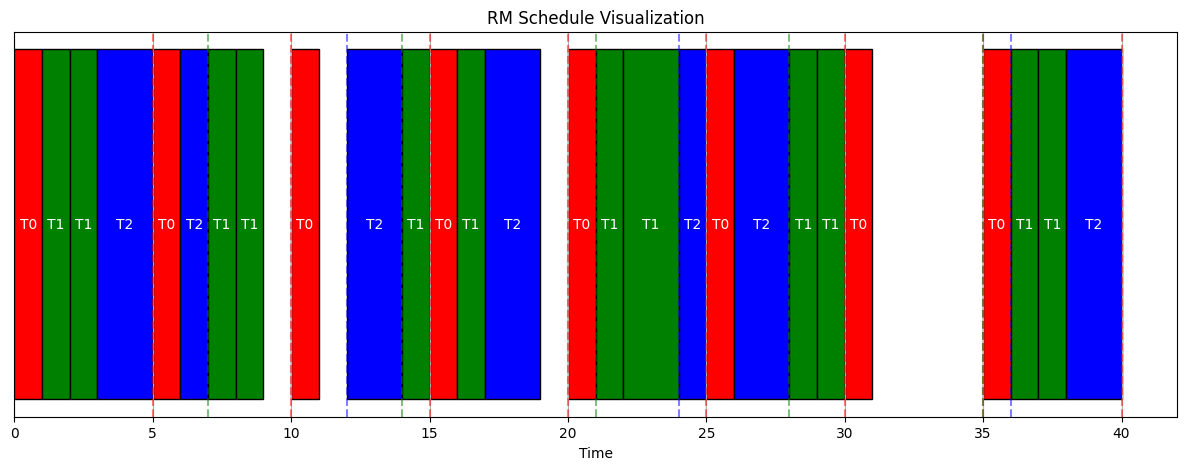


Job Execution Details:
Time | Task | Execution | Deadline
-----|------|-----------|---------
   0-1    | T0   |    1/1    | 5      
   1-2    | T1   |    1/2    | 7      
   2-3    | T1   |    2/2    | 7      
   3-5    | T2   |    2/3    | 12     
   5-6    | T0   |    1/1    | 10     
   6-7    | T2   |    3/3    | 12     
   7-8    | T1   |    1/2    | 14     
   8-9    | T1   |    2/2    | 14     
  10-11   | T0   |    1/1    | 15     
  12-14   | T2   |    2/3    | 24     
  14-15   | T1   |    1/2    | 21     
  15-16   | T0   |    1/1    | 20     
  16-17   | T1   |    2/2    | 21     
  17-19   | T2   |    4/3    | 24     
  20-21   | T0   |    1/1    | 25     
  21-22   | T1   |    1/2    | 28     
  22-24   | T1   |    3/2    | 28     
  24-25   | T2   |    1/3    | 36     
  25-26   | T0   |    1/1    | 30     
  26-28   | T2   |    3/3    | 36     
  28-29   | T1   |    1/2    | 35     
  29-30   | T1   |    2/2    | 35     
  30-31   | T0   |    1/1    | 35     
  35-36  

C:\Users\mi\AppData\Local\Temp\ipykernel_52228\302572003.py:187: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(all_tasks))


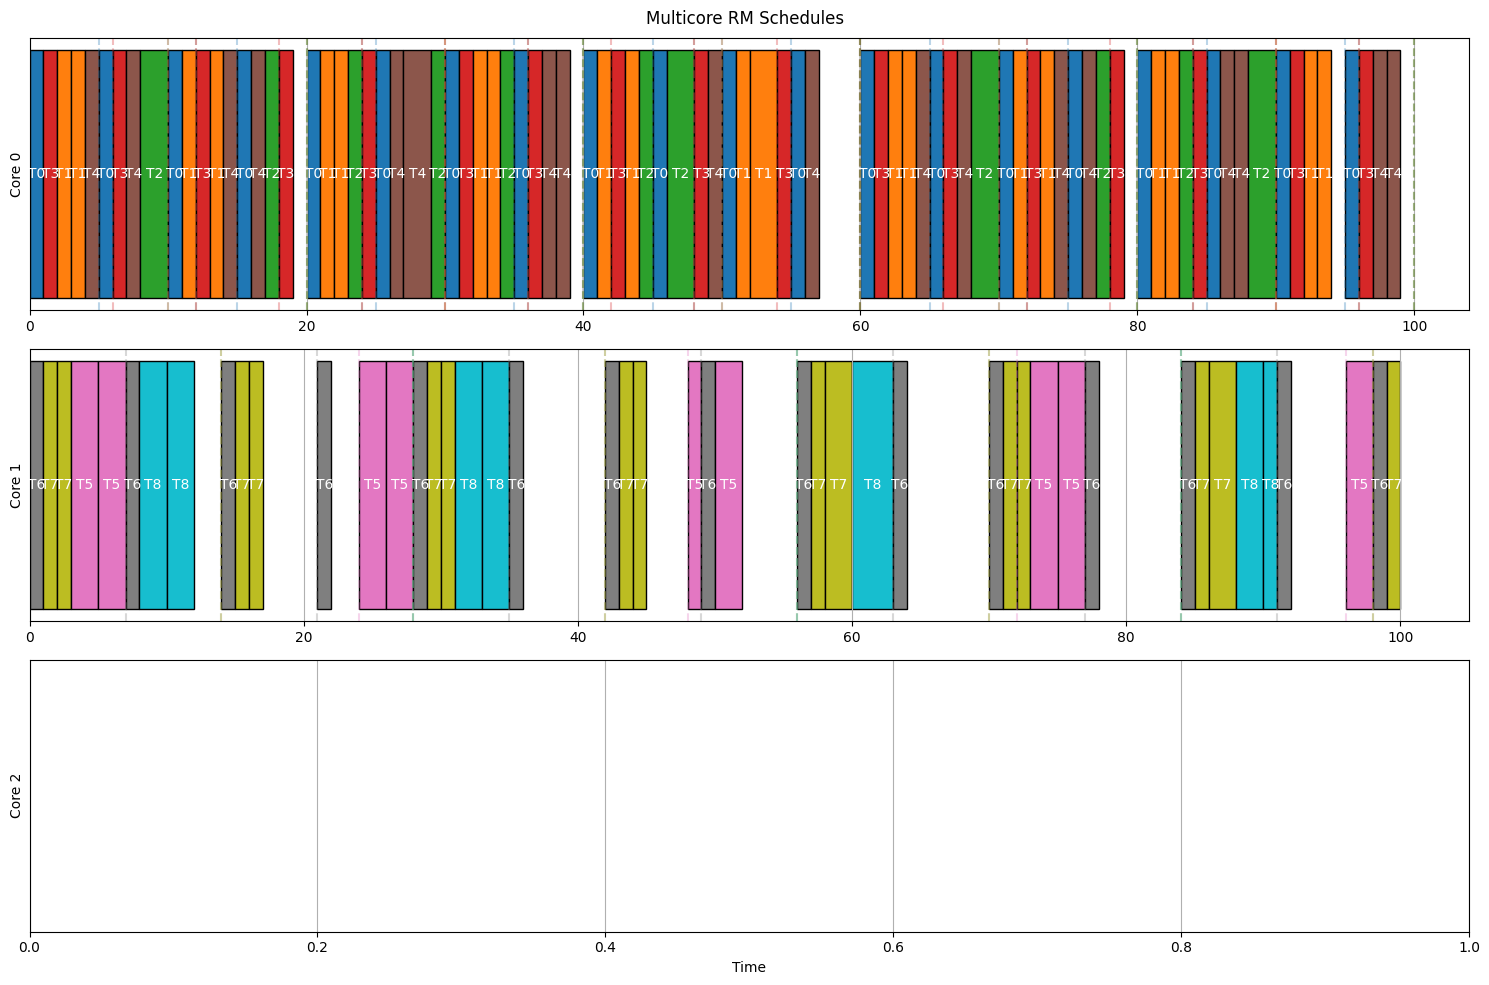


=== Multicore RM Results ===

Core Statistics:
Core | Tasks | Utilization | Missed Deadlines
-----|-------|-------------|-----------------
   0 |     5 |        0.89 |               0
   1 |     4 |        0.52 |               0
   2 |     0 |        0.00 |               0

Tasks with Missed Deadlines:
Task | Core | Period | WCET | Jobs | Missed | Response
-----|------|--------|------|------|--------|---------

RM Property Verification per Core:

Core 0:
Tasks: [0, 1, 2, 3, 4]
Utilization: 0.890
Liu & Layland bound: 0.743
✗ Fails LL test (may still be schedulable)
  Note: System is empirically schedulable despite failing LL test

Core 1:
Tasks: [5, 6, 7, 8]
Utilization: 0.515
Liu & Layland bound: 0.757
✓ Passes LL schedulability test

Core 2:
Tasks: []
Utilization: 0.000
Liu & Layland bound: 0.000
✓ Passes LL schedulability test

=== Testing Non-Preemptive RM (1 core, 3 tasks) ===


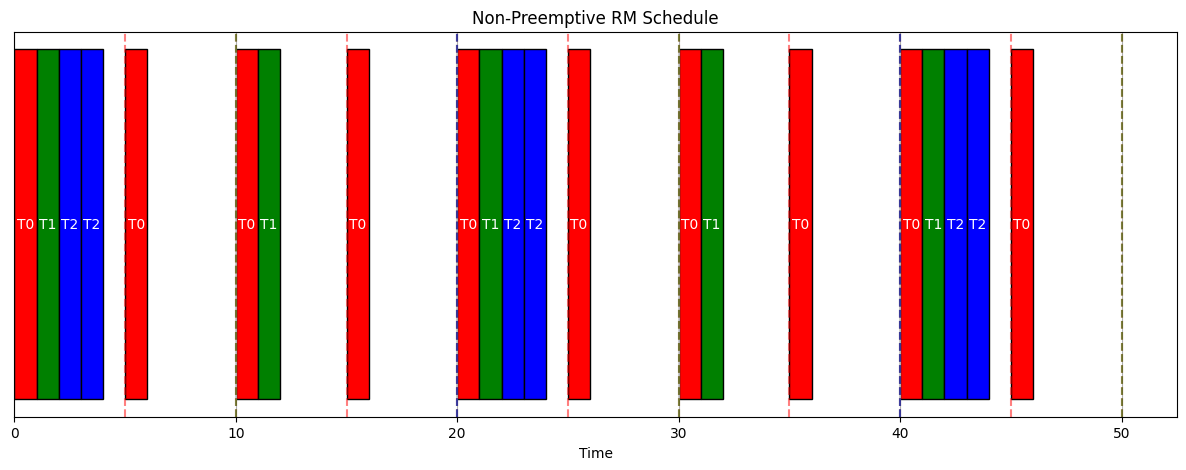


Non-Preemptive RM Results:
Task | Period | WCET | Jobs | Missed | Max Response
-----|--------|------|------|--------|-------------
T   0 |      5 |    1 |   10 |      0 |           1
T   1 |     10 |    1 |    5 |      0 |           2
T   2 |     20 |    2 |    3 |      0 |           4

Priority Inversion Check:
Priority inversion at time 3-4: T2 (period 20) ran before T0 (period 5)
Priority inversion at time 11-12: T1 (period 10) ran before T0 (period 5)
Priority inversion at time 23-24: T2 (period 20) ran before T0 (period 5)
Priority inversion at time 31-32: T1 (period 10) ran before T0 (period 5)
Priority inversion at time 43-44: T2 (period 20) ran before T0 (period 5)


In [6]:

if __name__ == "__main__":
    # Run basic RM test
    test_rm_scheduling()
    
    # Run multicore RM test
    test_multicore_rm()
    
    # Run non-preemptive RM test
    test_nonpreemptive_rm()